<a href="https://colab.research.google.com/github/mnguyen1901/RSNA_mammogram/blob/main/Vit_224.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
import torch
from tqdm.notebook import tqdm
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from itertools import product

from sklearn.metrics import f1_score
from torchvision.io import read_image
from torchvision import transforms
from torchvision.transforms import Resize
from torch.utils.data import Dataset, TensorDataset, DataLoader, WeightedRandomSampler
from torch import nn
from torch.optim import AdamW
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

from transformers import ViTConfig, ViTModel, get_scheduler

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [ ]:
os.listdir()

['Untitled (1)',
 'Untitled',
 'Sentence Encoder.ipynb',
 'RadStudies_clusterNumber.ipynb',
 'COVID cases.ipynb',
 'sample_submission.csv',
 'test.csv',
 'train.csv',
 'Untitled0.ipynb',
 'vit_saved',
 'X_Vin_eq.pt',
 'X_RSNA_eq.pt',
 'X_CBIS_eq.pt',
 'Vit-224 (1).ipynb',
 'X_RSNA_clahe.pt',
 'X_Vin_clahe.pt',
 'X_CBIS_clahe.pt',
 'y_RSNA.pt',
 'y_train.pt',
 'X_train.pt',
 'X_val.pt',
 'y_val.pt',
 'Vit-224.ipynb']

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [ ]:
pd.read_csv("test.csv")

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id
0,2,10008,736471439,L,MLO,81,0,21,10008_L
1,2,10008,1591370361,L,CC,81,0,21,10008_L
2,2,10008,68070693,R,MLO,81,0,21,10008_R
3,2,10008,361203119,R,CC,81,0,21,10008_R


In [ ]:
train_df = pd.read_csv("train.csv")
train_df.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [ ]:
X_train = torch.load("X_train.pt")
y_train = torch.load("y_train.pt")
X_val = torch.load("X_val.pt")
y_val = torch.load("y_val.pt")

print(X_train.size())
print(y_train.size())
print(X_val.size())
print(y_val.size())

torch.Size([36640, 2, 224, 224])
torch.Size([36640])
torch.Size([6490, 2, 224, 224])
torch.Size([6490])


tensor(71.8687) +/- tensor(58.0633)

In [ ]:
X_train = (X_train - 71.8687)/58.0633
X_val = (X_val - 71.8687)/58.0633

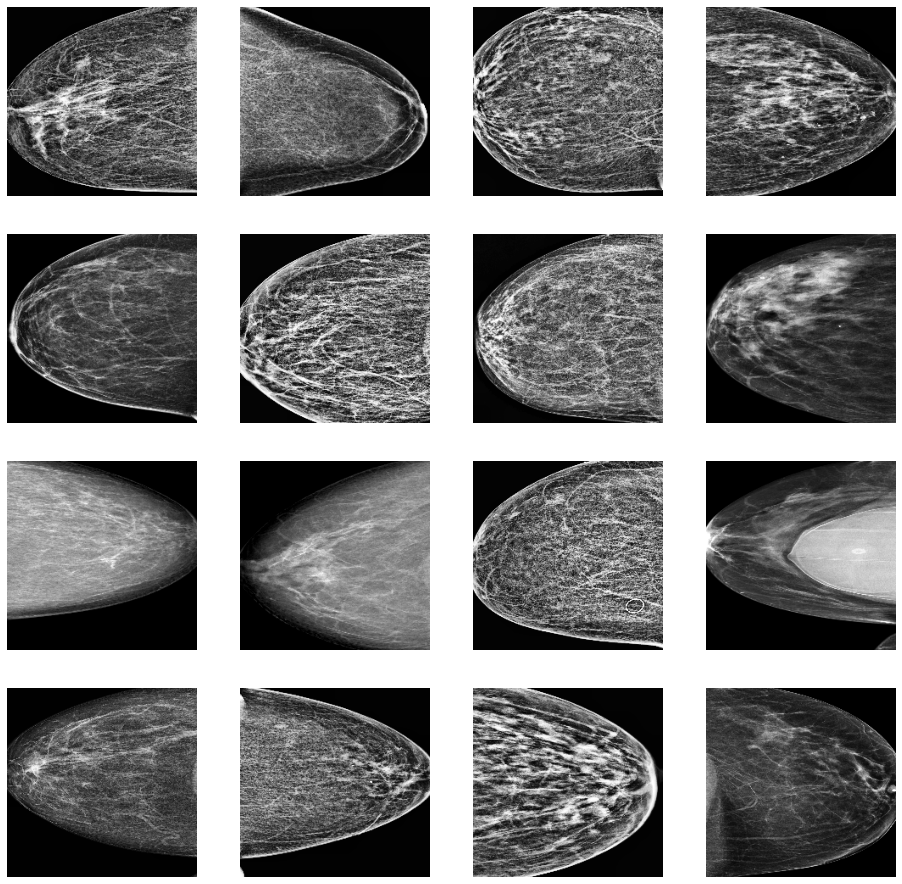

In [ ]:
plt.figure(figsize=(16,16))

for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.imshow(X_train[i*4+j][0], cmap="gray")
        plt.axis("off")

In [ ]:
class TransformedDataset(Dataset):
    def __init__(self, X, y, transform):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        image = self.X[index]
        cc = image[0]
        mlo = image[1]

        cc = cc.expand(3,-1,-1)
        mlo = mlo.expand(3,-1,-1)

        if self.transform:
            cc = self.transform(cc)
            mlo = self.transform(mlo)
        label = self.y[index]

        return (cc, mlo, label)

In [ ]:
def pf1(labels, preds, beta=1):
    preds = preds.clip(0, 1)
    y_true_count = sum(labels)
    ctp = sum(preds[labels==1])
    cfp = sum(preds[labels==0])
    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0.0

In [ ]:
def evaluate(model, dataloader):
    predictions = []
    y_true = []
    loss_epoch = 0

    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            cc = batch[0].to(device)
            mlo = batch[1].to(device)
            y = batch[2].to(device)
            outputs = model(cc, mlo)

            loss = model.loss_fn(outputs, y)

            loss_epoch += loss.item()
            predictions += torch.squeeze(outputs).tolist()
            y_true += torch.squeeze(y).tolist()

            del cc, mlo, y
            torch.cuda.empty_cache()

    y_proba = (torch.Tensor(predictions)).numpy()

    # Metrics
    f1 = pf1(np.array(y_true).astype(int), y_proba)

    return loss_epoch/len(dataloader), f1, y_proba, y_true

In [ ]:
model_names = ["google/vit-base-patch16-224-in21k", "google/vit-base-patch32-224-in21k",
               "google/vit-large-patch16-224-in21k", "google/vit-large-patch32-224-in21k"]

In [ ]:
print(X_val.size())
print(y_val.size())

torch.Size([6490, 2, 224, 224])
torch.Size([6490])


In [ ]:
class vit2x(nn.Module):
    def __init__(self, model_name, hidden_dropout_prob, attention_probs_dropout_prob, attention_heads, hidden_layers):
        super(vit2x, self).__init__()

        self.vit = ViTModel.from_pretrained(model_name,
                                            hidden_dropout_prob=hidden_dropout_prob,
                                            attention_probs_dropout_prob=attention_probs_dropout_prob,
                                            num_hidden_layers=hidden_layers,
                                            num_attention_heads=attention_heads)
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(768, 1)
        )

    def forward(self, cc, mlo):
        cc_output = self.vit(cc)
        mlo_output = self.vit(mlo)

        cc_output = cc_output.last_hidden_state
        mlo_output = mlo_output.last_hidden_state

        cc_output = cc_output[:, 0, :]
        mlo_output = mlo_output[:, 0, :]

        viewpool = torch.max(torch.stack([cc_output, mlo_output]), 0).values

        outputs = self.classifier(viewpool)

        return nn.Sigmoid()(outputs)

In [ ]:
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=45, fill=-1)
])

y_train_np = torch.squeeze(y_train).cpu().detach().numpy().astype(int)
count = [len(y_train_np) - sum(y_train_np) , sum(y_train_np)]
w = [1/count[i] for i in y_train_np]

train_data = TransformedDataset(X_train.float(), y_train.float().unsqueeze(-1), transform=data_transform)
val_data = TransformedDataset(X_val.float(), y_val.float().unsqueeze(-1), transform=data_transform)

sampler = WeightedRandomSampler(weights=w, num_samples=len(y_train), replacement=True)
train_dataloader = DataLoader(train_data, sampler=sampler, batch_size=1024, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=1024, pin_memory=True)

In [ ]:
for batch in train_dataloader:
    break

sum(batch[2])

tensor([530.])

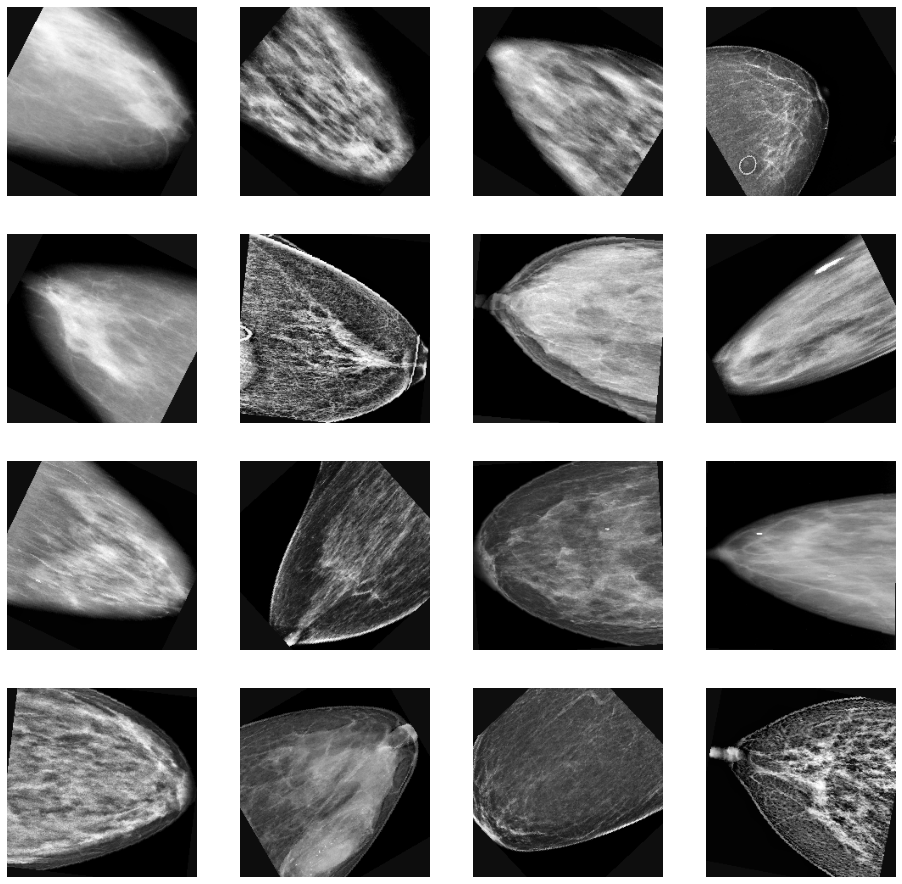

In [ ]:
#view data fed into model
plt.figure(figsize=(16,16))

pic_num = 0
for i in range(4):
    for j in range(4):
        plt.subplot(4,4,i*4+j+1)
        plt.imshow(batch[0][pic_num][0], cmap="gray")
        plt.axis("off")
        pic_num += 1

In [ ]:
epochs = 30
hidden_dropout_prob = 0.2
attention_probs_dropout_prob = 0.2
hidden_layers = 12
attention_heads = 12
lr = 1e-3

model_name_or_path = "google/vit-base-patch16-224-in21k"
vit = vit2x(model_name_or_path, hidden_dropout_prob, attention_probs_dropout_prob, attention_heads, hidden_layers)

for param in vit.vit.parameters():
    param.requires_grad = False

vit.to(device)
vit.loss_fn = torch.nn.MSELoss()

In [ ]:
num_training_steps = epochs * len(train_dataloader)
progress_bar = tqdm(range(num_training_steps))

optimizer = AdamW(vit.parameters(), lr=lr, weight_decay=0.01)
lr_scheduler = get_scheduler(name="cosine",
                            optimizer=optimizer,
                            num_warmup_steps=num_training_steps*0.1,
                            num_training_steps=num_training_steps)

best_loss = 1e5
best_f1 = 0
no_improvement = 0
total_loss_train = []
total_loss_val = []
f1_val = []
f1_train = []

print("Finish warming up at epoch =", num_training_steps/len(train_dataloader))
print("Epoch", " "*5,
    "Train loss", " "*5,
    "Val loss", " "*5,
    "F1 Val/Train")

vit.train()
for epoch in range(epochs):
    loss_epoch_train = 0

    for batch in train_dataloader:
        cc = batch[0].to(device)
        mlo = batch[1].to(device)
        y = batch[2].to(device)
        outputs = vit(cc, mlo)
        loss = vit.loss_fn(outputs, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(vit.parameters(), 1.0)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.update(1)
        loss_epoch_train += loss.item()

        del cc, mlo, y
        torch.cuda.empty_cache()

    total_loss_train.append(loss_epoch_train/len(train_dataloader))
    loss_epoch_val, f1_epoch_val, y_proba, y_true = evaluate(vit, val_dataloader)
    _, f1_epoch_train, _, _ = evaluate(vit, train_dataloader)
    total_loss_val.append(loss_epoch_val)

    f1_val.append(f1_epoch_val)
    f1_train.append(f1_epoch_train)

    print(epoch, " "*(10-len(str(epoch))),
        str(total_loss_train[-1])[:6], " "*9,
        str(loss_epoch_val)[:6], " "*7,
        str(f1_epoch_val)[:4], "/", str(f1_epoch_train)[:4])

    if loss_epoch_val < best_loss:
        best_loss = loss_epoch_val
        no_improvement = 0
        torch.save(vit.state_dict(), "classifier_only.pt")
    elif epoch>20:
        no_improvement += 1

    if no_improvement == 10:
        break

  0%|          | 0/1080 [00:00<?, ?it/s]

Finish warming up at epoch = 30.0
Epoch       Train loss       Val loss       F1 Val/Train
0           0.2510           0.2399         0.04 / 0.51
1           0.2284           0.2015         0.04 / 0.54
2           0.2036           0.1507         0.04 / 0.56
3           0.1902           0.1399         0.03 / 0.59
4           0.1846           0.1408         0.04 / 0.60
5           0.1804           0.1232         0.03 / 0.61
6           0.1774           0.1266         0.04 / 0.61


KeyboardInterrupt: ignored

In [ ]:
plt.figure(figsize = (8,4))

plt.subplot(1,2,1)
plt.plot(range(len(total_loss_train)), total_loss_train)
plt.plot(range(len(total_loss_val)), total_loss_val)
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(range(len(f1_val)), f1_val)
plt.plot(range(len(f1_train)), f1_train)
plt.title("F1")